In [33]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io
import seaborn as sns
#sns.set_style("darkgrid")
import sklearn

### Reading in data
#### selecting the relevant columns

In [34]:
# choose between the normalized or standardized version of the data
air_data_all = pd.read_csv('Data/data_4comp_std_labeled.csv', delimiter=',')

# select only the columns that pca will be used on
cols = ["PM2.5","PM10","NO2","O3"]   
air_data= air_data_all[cols]

# colums with the ratings: categories 1,2,3,4
ratings = air_data_all['cat'] 
cat_labels = ["very low air quality", "low air quality", "medium air quality",  "good air quality"]

### Calculate SVD, eigenvectors and eigenvalues

In [35]:
# calculation of svd
u, s, vh = np.linalg.svd(air_data, 
                         full_matrices=True) 
eigenval, eigenvec = s ** 2, vh

In [36]:
## Calculate the coordinates of the data points in the projection axes of the space spanned 
## by the leading eigenvectors contained in $U$ 
u1 = u[:,0] * s[0] 
u2 = u[:,1] * s[1] 
u3 = u[:,2] * s[2]

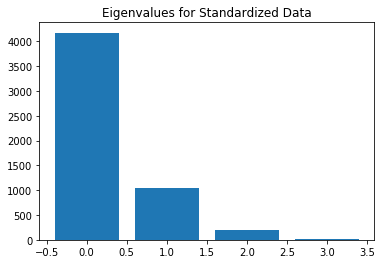

In [37]:
%matplotlib inline

# Sort eigenvectors (and -values) by descending order of eigenvalues.
sort = np.argsort(-eigenval)
eigenval = eigenval[sort]
eigenvec = eigenvec[:,sort]

# To get an idea of the eigenvalues we plot them.
figure = plt.figure('Eigenvalue comparison')
plt.bar(np.arange(len(eigenval)), eigenval)
plt.title('Eigenvalues for Standardized Data')
plt.savefig("Plots/eigenvalues_std.png")

## 2D SVD Projection

In [79]:
# define colors for the groups
colors = [ "#c70039", "#fa7f1d", "#FFC300" , "#97e115"  ]

In [41]:
# By SVD
projected_x= np.dot(air_data,vh.T)
v_norm= np.dot(vh.T, vh)


names = ["SVD-PC_"+str(x+1) for x in range(2)]
names.append('cat')
ds_svd = pd.DataFrame(data= np.c_[projected_x[:,0:2], air_data_all.cat], 
                      columns=names)
ds_svd['cat'] = ds_svd['cat'].astype(int)

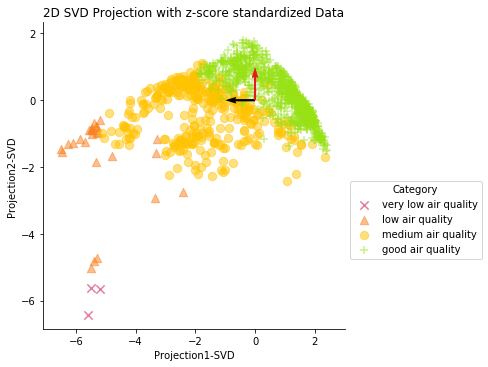

In [58]:
sns.lmplot('SVD-PC_1', 
           'SVD-PC_2', 
           data=ds_svd, 
           hue='cat', 
           markers=['x','^','o','+'],
           palette=sns.color_palette(colors,4),
           fit_reg=False,
           legend=False,
           scatter_kws={'alpha':0.5, "s": 70}, 
           height=5)
plt.quiver(0, 0, -v_norm[0,0],v_norm[1,0], scale_units='xy', angles='xy', scale=1, color = '#000000')
plt.quiver(0, 0, v_norm[0,1],v_norm[1,1], scale_units='xy', angles='xy', scale=1, color = '#e41a1c')
plt.xlabel('Projection1-SVD')
plt.ylabel('Projection2-SVD')
lgd = plt.legend(bbox_to_anchor=(1, 0.5), title='Category', labels = cat_labels);
ttl = plt.title('2D SVD Projection with z-score standardized Data', fontsize = "large")
#plt.savefig("Plots/svd_2d_std_groups.png")

## 3D SVD Projection


In [43]:
# groups of air quality
cat4 = ds_us[ds_us["cat"] == 4]
cat3 = ds_us[ds_us["cat"] == 3]
cat2 = ds_us[ds_us["cat"] == 2]
cat1 = ds_us[ds_us["cat"] == 1]


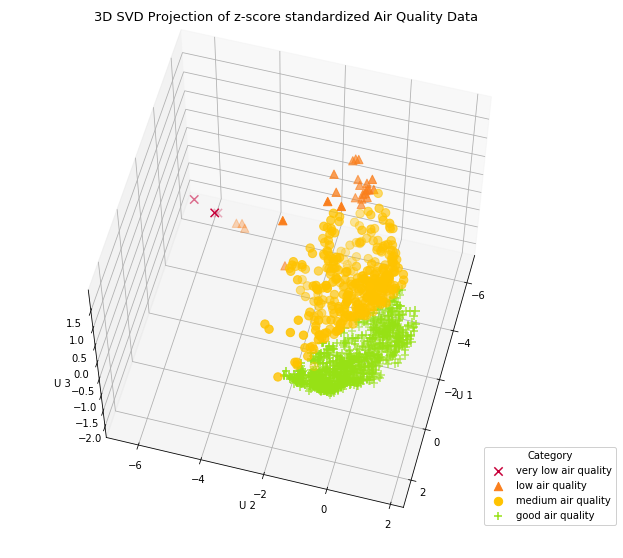

In [60]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# plot each air quality group individually
ax.scatter(cat1["U_1"], cat1["U_2"], cat1["U_3"], s=70, marker='x', c= colors[0])
ax.scatter(cat2["U_1"], cat2["U_2"], cat2["U_3"], s=70, marker='^', c= colors[1])
ax.scatter(cat3["U_1"], cat3["U_2"], cat3["U_3"], s=70, marker='o', c= colors[2])
ax.scatter(cat4["U_1"], cat4["U_2"], cat4["U_3"], s=70, marker='+', c= colors[3])

ax.set_xlabel('U 1')
ax.set_ylabel('U 2')
ax.set_zlabel('U 3')
ax.view_init(60,15)
ax.set_title('3D SVD Projection of z-score standardized Air Quality Data', fontsize= 13,  pad=30);
ax.legend(bbox_to_anchor=(1.1, 0.2), title='Category', labels = cat_labels, framealpha=0.9 );
#plt.savefig("Plots/svd_3d_std_groups.png",  bbox_inches='tight')

## Quality of projection

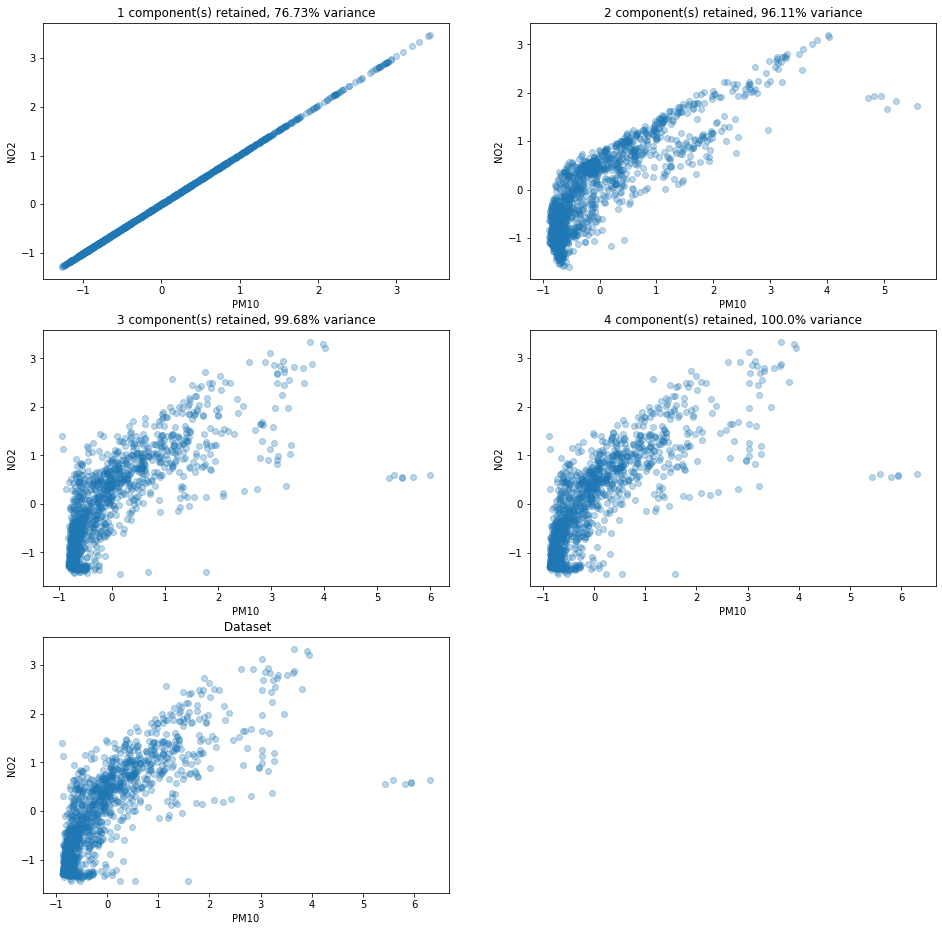

In [45]:
r = air_data.shape[1]
var_explained = np.cumsum(s**2)/np.sum(s**2)*100;

# You can change the features you would like to display, from 0 to 10
# ["PM2.5","PM10","NO2","O3"]

f1=1   #pm2.5
f2=2  #o3
fig, axs = plt.subplots(3,2, figsize=(16,16))
axs = axs.ravel()
approx = []

for n in range(1,r+1):
    approximation = np.dot((u[:,:n] * s[:n]),vh[:n,:]) 
    
    approx.append(approximation)
    
    #fig.add_subplot(1, 2, 1)
    sns.regplot(x=approximation[:,f1],
                y=approximation[:,f2],
                fit_reg=False,
                scatter_kws={'alpha':0.3}, ax=axs[n-1])
    axs[n-1].set(xlabel= 'PM10', 
           ylabel= 'NO2',
           title= (str(n) 
                   + ' component(s) retained, ' 
                   + str(round(var_explained[n-1],2)) 
                   + '% variance'))
    
sns.regplot(x=np.array(air_data)[:,f1],
            y=np.array(air_data)[:,f2],
            fit_reg=False,
            scatter_kws={'alpha':0.3}, ax=axs[4])
axs[4].set(xlabel='PM10', 
       ylabel= 'NO2',
       title=' Dataset');
    
fig.delaxes(axs[5])
fig.savefig("Plots\quality_svd.svg")

## Hidden factor model
### compute scoring in 0-100 rank scale

In [74]:
z, mu, c = np.linalg.svd(air_data, full_matrices=True)
ds = np.sum(np.sum(air_data.T @ air_data))

z1 = z[:,0]  # first singular 1340D scoring vector
mu_max = mu[0]
c1 = c[:,0]

print("c: \n", c)
for i in range(len(mu)):
    print("component ", i, ": influence: ", np.round(mu[i]**2 / ds * 100, 1), " %")

c: 
 [[-0.53439699 -0.52622558 -0.53376742  0.39063901]
 [-0.37875802 -0.41123258  0.19482816 -0.80589833]
 [-0.19579188 -0.3027146   0.81991876  0.44470512]
 [ 0.72981351 -0.67995461 -0.06976788 -0.01289986]]
component  0 : influence:  50.7  %
component  1 : influence:  12.8  %
component  2 : influence:  2.4  %
component  3 : influence:  0.2  %


In [75]:
# rescale z to convert it to 0-100 scale
alpha = 1/np.sum(c1)
print(alpha)

z_scaled = c1 * alpha
z_scaled

-2.6375942242118717


array([ 1.40952242,  0.99900996,  0.51641952, -1.9249519 ])

### Calculate Model according to Mirkin, 2009: 215

In [76]:
# calculate new hidden factor and loading by multiplying it with the sqrt of the maximum singular value
# --> formula slide 17
mu_sqrt = np.sqrt(mu[0])
z_new = np.expand_dims(z[:,0] * mu_sqrt, axis=1)
c_new = np.expand_dims(c[:,0] * mu_sqrt, axis=1)

In [77]:
# calcualte the model, derive the residuals as difference between model and obversed data
model = z_new @ c_new.T
residuals = air_data - model

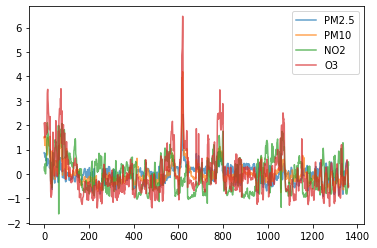

In [68]:
plt.plot(residuals, alpha=0.7)
plt.legend(residuals.columns)
plt.savefig("Plots/residuals_hidden.svg")